# 環境設定

## 引入必要函式庫

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

## 載入資料集

In [ ]:
from keras.datasets import mnist

(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1 to fit tanh() activation function of Output Layer
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Add a color channel dimension, from (60000, 28, 28) to (60000, 28, 28, 1)
X_train =  np.expand_dims(X_train, axis=3)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 超參數設定

In [ ]:
# Set the shape of MNIST
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

# Set the length of noise for GANs generator Input Layer
z_dim = 100

# Set the number of training epochs
epochs = 10000

# Set the batch size
batch_size = 128

# Set how many times of training should show acc / loss once
sample_interval = 100

# 定義模型

## 定義生成器（Generator）

In [ ]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Input(shape=(z_dim,)))
    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

## 定義鑑別器（Discriminator）

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Input(shape=img_shape))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

## 定義生成器與鑑別器組合函數

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

## 生成整個 GAN 模型

In [ ]:
# Create and Compile Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Create and Compile Generator
generator = build_generator(img_shape, z_dim)

# Create and Compile GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# 訓練模型

## 定義訓練過程中，秀圖的函數

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # Sample random noise
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(noise)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## 定義訓練函數

* 自訂訓練函數的原因：希望能觀察到「訓練到一半」所產生出來的圖片

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # Turn off the stdout temporarily
        # To supress 4/4 [=====================] - 0s 3ms/step
        original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

        # ---- Train the Discriminator ----

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)

        # Train Discriminator
        discriminator.trainable = True  # 開放權重訓練
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        discriminator.trainable = False  # 凍結權重訓練
        d_loss = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])  # 計算損失值
        accuracy = 0.5 * np.add(d_loss_real[1], d_loss_fake[1])  # 計算準確率

        # ---- Train the Generator ----

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, z_dim))

        # Set the Noise as True in purpose
        g_loss = gan.train_on_batch(noise, real)[0]  # 只取得損失值

        # Turn stdout back on
        sys.stdout.close()
        sys.stdout = original_stdout

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("{:d} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

## 開始訓練模型

100 [D loss: 0.1177, acc.: 94.40%] [G loss: 0.1174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


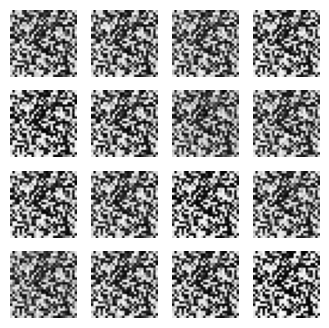

200 [D loss: 0.0607, acc.: 97.20%] [G loss: 0.0606]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


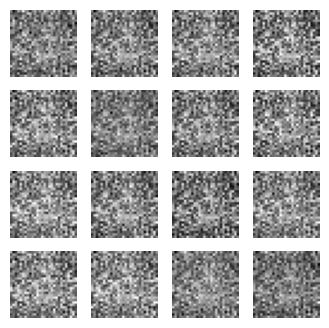

300 [D loss: 0.0536, acc.: 98.13%] [G loss: 0.0536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


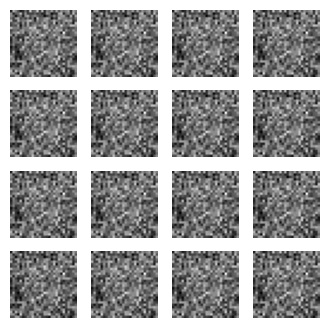

400 [D loss: 0.0459, acc.: 98.60%] [G loss: 0.0459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


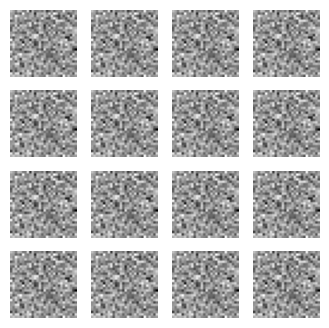

500 [D loss: 0.0380, acc.: 98.88%] [G loss: 0.0379]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


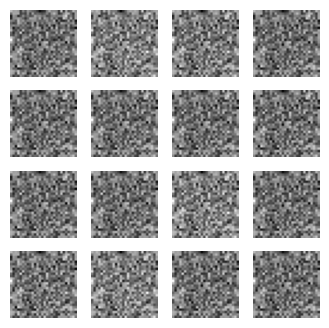

600 [D loss: 0.0322, acc.: 99.07%] [G loss: 0.0322]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


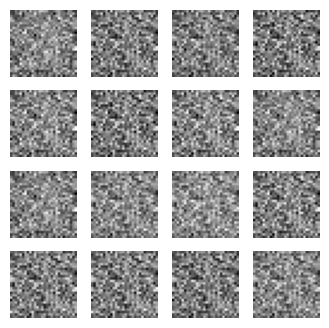

700 [D loss: 0.0279, acc.: 99.20%] [G loss: 0.0279]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


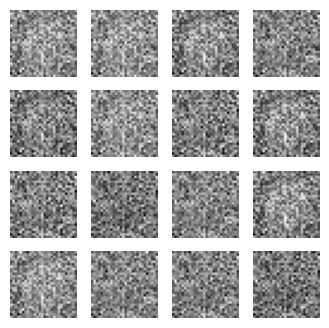

800 [D loss: 0.0247, acc.: 99.30%] [G loss: 0.0247]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


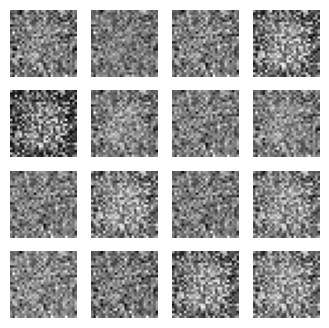

In [ ]:
train(iterations=epochs, batch_size=batch_size, sample_interval=sample_interval)